# Derivative Study
Goal: Determine the proper shape of the Sparsity Pattern to account for all turbines that actually matter.

Secondary Goal: Modify code for higher speed

## Inital Setup

In [5]:
using DelimitedFiles
import ForwardDiff
import FLOWFarm; const ff = FLOWFarm
using SparseArrays
using LinearAlgebra
using SparsityDetection, SparseArrays, SparseDiffTools
using FLOWMath: gradient
using Plots
using LinearAlgebra
using BenchmarkTools
using Colors

struct params_struct{MS, AF, F, AI, ACTM, WR, APM, SPAF, SPAF2D}
    model_set::MS
    rotor_points_y::AF
    rotor_points_z::AF
    turbine_z::AF
    rotor_diameter::AF
    boundary_center::AF
    boundary_radius::F
    obj_scale::F
    hub_height::AF
    turbine_yaw::AF
    ct_models::ACTM
    generator_efficiency::AF
    cut_in_speed::AF
    cut_out_speed::AF
    rated_speed::AF
    rated_power::AF
    windresource::WR
    power_models::APM
    i::AI
    dx::SPAF
    jac::SPAF2D
    color::SPAF
end

# set up boundary constraint wrapper function
function boundary_wrapper(x, params)

    # get number of turbines
    nturbines = Int(length(x)/2)
    
    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines]
    turbine_y = x[nturbines+1:end]

    # get and return boundary distances
    return ff.circle_boundary(params.boundary_center, params.boundary_radius, turbine_x, turbine_y)
end

# set up spacing constraint wrapper function
function spacing_wrapper(x, params)
    
    # get number of turbines
    nturbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines]
    turbine_y = x[nturbines+1:end]

    # get and return spacing distances
    return 2.0*params.rotor_diameter[1] .- ff.turbine_spacing(turbine_x,turbine_y)
end

# set up objective wrapper function
function aep_wrapper(x, params)

    # get number of turbines
    nturbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines] 
    turbine_y = x[nturbines+1:end]

    # calculate AEP
    obj_scale = params.obj_scale
    AEP = obj_scale*ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
                params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
                params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z)
    
    # return the objective as an array
    return [AEP]
end

function p_wrapper(x)
    n = Int(length(x)/2)
    turbine_x = x[1:n]
    turbine_y = x[n+1:end]

    rot_x, rot_y = ff.rotate_to_wind_direction(turbine_x, turbine_y, params.windresource.wind_directions[state])
    sorted_turbine_index = sortperm(rot_x)
    turbine_velocities = ff.turbine_velocities_one_direction(rot_x, rot_y, params.turbine_z, params.rotor_diameter, params.hub_height, params.turbine_yaw,
                            sorted_turbine_index, params.ct_models, params.rotor_points_y, params.rotor_points_z, params.windresource,
                            params.model_set, wind_farm_state_id=state, velocity_only=true)

    wt_power = ff.turbine_powers_one_direction(params.generator_efficiency, params.cut_in_speed, params.cut_out_speed, params.rated_speed,
                            params.rated_power, params.rotor_diameter, turbine_velocities, params.turbine_yaw, params.windresource.air_density, params.power_models)
end

function p_wrapper_single(x)
    n = Int(length(x)/2)
    turbine_x = x[1:n]
    turbine_y = x[n+1:end]

    rot_x, rot_y = ff.rotate_to_wind_direction(turbine_x, turbine_y, params.windresource.wind_directions[state])
    sorted_turbine_index = sortperm(rot_x)
    turbine_velocities = ff.turbine_velocities_one_direction(rot_x, rot_y, params.turbine_z, params.rotor_diameter, params.hub_height, params.turbine_yaw,
                            sorted_turbine_index, params.ct_models, params.rotor_points_y, params.rotor_points_z, params.windresource,
                            params.model_set, wind_farm_state_id=state, velocity_only=true)


    wt_power = ff.turbine_powers_one_direction(params.generator_efficiency, params.cut_in_speed, params.cut_out_speed, params.rated_speed,
                            params.rated_power, params.rotor_diameter, turbine_velocities, params.turbine_yaw, params.windresource.air_density, params.power_models)

    return wt_power .* 24 .* 365.25 .* params.obj_scale
end

function p_wrapper!(wt_power,x)
    n = Int(length(x)/2)
    turbine_x = x[1:n]
    turbine_y = x[n+1:end]

    rot_x, rot_y = ff.rotate_to_wind_direction(turbine_x, turbine_y, params.windresource.wind_directions[state])
    sorted_turbine_index = sortperm(rot_x)
    turbine_velocities = ff.turbine_velocities_one_direction(rot_x, rot_y, params.turbine_z, params.rotor_diameter, params.hub_height, params.turbine_yaw,
                            sorted_turbine_index, params.ct_models, params.rotor_points_y, params.rotor_points_z, params.windresource,
                            params.model_set, wind_farm_state_id=state, velocity_only=true)

    wt_power[:] = ff.turbine_powers_one_direction(params.generator_efficiency, params.cut_in_speed, params.cut_out_speed, params.rated_speed,
                            params.rated_power, params.rotor_diameter, turbine_velocities, params.turbine_yaw, params.windresource.air_density, params.power_models)[:]
    
    nothing
end

function loadAllParam(dirs,num,angle)
    cd("/Users/benjaminvarela/.julia/dev/FLOWFarm/test")

    # scale objective to be between 0.1 and 1
    if num == 38
        obj_scale = 1E-18
    else
        obj_scale = 1E-13
    end

    # set initial turbine x and y locations
    diam = 80.0
    data = readdlm("inputfiles/layout_38turb_round.txt",  ' ', skipstart=1)
    turbine_x = data[:, 1].*diam
    nturbines = length(turbine_x)
    nturbines = num
    turbine_y = data[:, 2].*diam
    turbine_z = zeros(nturbines)

    turbine_x = turbine_x .- turbine_x[1]
    turbine_y = turbine_y .- turbine_y[1]

    angle = 270 + angle

    turbine_x, turbine_y = ff.rotate_to_wind_direction(turbine_x, turbine_y, angle*pi/180)

    turbine_z = zeros(nturbines)
    
    # set turbine base heights
    turbine_z = zeros(nturbines) .+ 0.0
    
    # set turbine yaw values
    turbine_yaw = zeros(nturbines)
    
    # set turbine design parameters
    rotor_diameter = zeros(nturbines) .+ diam # m
    hub_height = zeros(nturbines) .+ 70.0   # m
    cut_in_speed = zeros(nturbines) .+ 0.  # m/s 4.0
    cut_out_speed = zeros(nturbines) .+ 25.  # m/s
    rated_speed = zeros(nturbines) .+ 16.  # m/s
    rated_power = zeros(nturbines) .+ 2.0E6  # W
    generator_efficiency = zeros(nturbines) .+ 0.944
    
    # rotor swept area sample points (normalized by rotor radius)
    rotor_points_y = [0.0]
    rotor_points_z = [0.0]
    
    # set flow parameters
    if dirs == 12
        data = readdlm("inputfiles/windrose_nantucket_12dir.txt",  ' ', skipstart=1)
        winddirections = data[:, 1].*pi/180.0
        windspeeds = data[:,2]
        windprobabilities = data[:, 3]
        nstates = length(windspeeds)
    elseif dirs == 72
        data = readdlm("inputfiles/windrose_amalia_72dirs.txt",  ' ', skipstart=1)
        winddirections = data[:, 1].*pi/180.0
        windspeeds = data[:,2]
        windprobabilities = data[:, 3]
        nstates = length(windspeeds)
    else
        winddirections = [270.0*pi/180]
        windspeeds = [8.0]
        windprobabilities = [1.0]
        nstates = length(windspeeds)
    end
    
    
    air_density = 1.1716  # kg/m^3
    ambient_ti = 0.077
    shearexponent = 0.15
    ambient_tis = zeros(nstates) .+ ambient_ti
    measurementheight = zeros(nstates) .+ hub_height[1]
    
    # load power curve
    powerdata = readdlm("inputfiles/niayifar_vestas_v80_power_curve_observed.txt",  ',', skipstart=1)
    velpoints = powerdata[:,1]
    powerpoints = powerdata[:,2]*1E6
    
    # initialize power model
    power_model = ff.PowerModelCpPoints(velpoints, powerpoints)
    power_models = Vector{typeof(power_model)}(undef, nturbines)
    for i = 1:nturbines
        power_models[i] = power_model
    end
    
    # load thrust curve
    ctdata = readdlm("inputfiles/predicted_ct_vestas_v80_niayifar2016.txt",  ',', skipstart=1)
    velpoints = ctdata[:,1]
    ctpoints = ctdata[:,2]
    
    # initialize thurst model
    ct_model = ff.ThrustModelCtPoints(velpoints, ctpoints)
    ct_models = Vector{typeof(ct_model)}(undef, nturbines)
    for i = 1:nturbines
        ct_models[i] = ct_model
    end
    
    # initialize wind shear model
    wind_shear_model = ff.PowerLawWindShear(shearexponent)
    
    # get sorted indecies 
    # sorted_turbine_index = sortperm(turbine_x)
    
    # initialize the wind resource definition
    windresource = ff.DiscretizedWindResource(winddirections, windspeeds, windprobabilities, measurementheight, air_density, ambient_tis, wind_shear_model)
    
    # set up wake and related models
    wakedeficitmodel = ff.GaussYawVariableSpread()
    wakedeficitmodel.wec_factor[1] = 1.0
    
    wakedeflectionmodel = ff.GaussYawVariableSpreadDeflection()
    wakecombinationmodel = ff.LinearLocalVelocitySuperposition()
    localtimodel = ff.LocalTIModelNoLocalTI()
    
    # initialize model set
    model_set = ff.WindFarmModelSet(wakedeficitmodel, wakedeflectionmodel, wakecombinationmodel, localtimodel)
    
    # initialize sparse partial derivatives array for turbine velocity
    dx = spzeros(nturbines)
    
    # set wind farm boundary parameters
    boundary_center = [0.0,0.0]
    boundary_radius = 1225.8227848101264

    global state = 1
    
    global params = params_struct(model_set, rotor_points_y, rotor_points_z, turbine_z, 
    rotor_diameter, boundary_center, boundary_radius, obj_scale, hub_height, turbine_yaw, 
    ct_models, generator_efficiency, cut_in_speed, cut_out_speed, rated_speed, rated_power, 
    windresource, power_models, [0], dx, [spzeros(nturbines, 2*nturbines)], spzeros(2*nturbines));

    return turbine_x,turbine_y
end

spacing_wrapper(x) = spacing_wrapper(x, params)
aep_wrapper(x) = aep_wrapper(x, params)
boundary_wrapper(x) = boundary_wrapper(x, params)

boundary_wrapper (generic function with 2 methods)

## Sparsity Functions

In [6]:
function sparseAEPJacobian(x)
    n = length(x)
    TempSparseJacobian = zeros(1,n)
    sparseJacobian = spzeros(Int(n/2),n)
    for j = 1:length(params.windresource.wind_probabilities)
        global state = j
        windProb = params.windresource.wind_probabilities[j]
        if windProb == 0.0
            continue
        elseif params.windresource.wind_speeds[j] == 0.0
            continue
        end
        sparseJacobian = calculateSparseJacobian(x)
        
        for i = 1:n
            TempSparseJacobian[i] += sum(sparseJacobian[:,i])*windProb*365.25*24
        end
    end
    return TempSparseJacobian*params.obj_scale
end

function calculateSparseJacobian(x)
    n = Int(length(x)/2)
    jac = dropzeros(sparse(calculateSparsityPattern(x)))
    if iszero(jac)
        return jac
    end
    jac2 = similar(jac)
    cache = ForwardColorJacCache(p_wrapper!,x,
                              dx = similar(x[1:n]),
                              colorvec=matrix_colors(jac),
                              sparsity = jac)

    forwarddiff_color_jacobian!(jac2,
                            p_wrapper!,
                            x,
                            cache)
end

function calculateSparsityPattern(x)
    n = Int(length(x)/2)
    rot_x, rot_y = ff.rotate_to_wind_direction(x[1:n],x[n+1:end],params.windresource.wind_directions[state])

    rot_x = rot_x ./ params.rotor_diameter[1]
    rot_y = rot_y ./ params.rotor_diameter[1]
    sparsityPattern = zeros(n,n*2)
    sorted_index = sortperm(rot_x)
    d = 2.5
    
    # determine if current turbine is affected by the other turbines
    for i = 1:Int(length(x)/2)
        xCurrent = rot_x[i]
        yCurrent = rot_y[i]
        for j = 1:Int(length(x)/2)
            jt = sorted_index[j]
            xOther = rot_x[jt]
            xdif = xCurrent - xOther
            if i == jt
                sparsityPattern[i,jt+n] = 1.0
                sparsityPattern[i,jt] = 1.0
                continue
            elseif xdif < 0
                break
            end

            yOther = rot_y[jt]
            if yOther < yCurrent
                yOther = 2*yCurrent - yOther
            end

            ydif = yOther - yCurrent

            if (ydif) < d
                sparsityPattern[i,jt+n] = 1.0
                sparsityPattern[i,jt] = 1.0
                continue
            elseif xdif < 4.5
                continue
            end

            if ydif > (d + (xdif-4.5)*tand(7))
                continue
            else
                sparsityPattern[i,jt+n] = 1.0
                sparsityPattern[i,jt] = 1.0
            end
        end
    end
    return sparsityPattern
end

calculateSparsityPattern (generic function with 1 method)

## 2 Turbine System

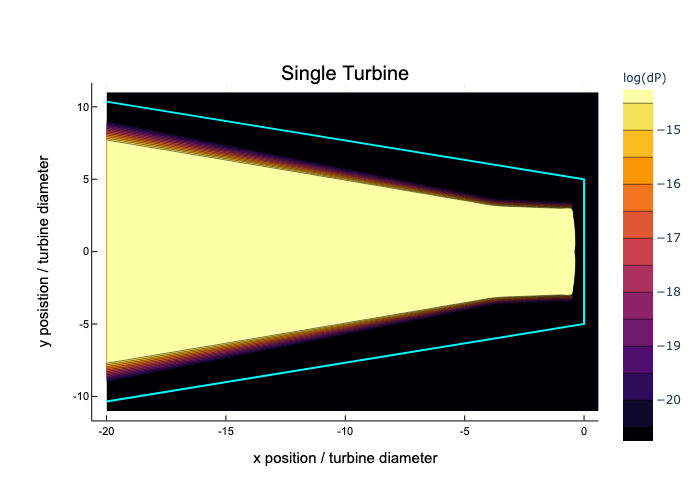

In [7]:
loadAllParam(0,2,0)
x_turbines = [0;-15] .*80
y_turbines = [0;0] .*80
x = [copy(x_turbines);copy(y_turbines)]

plotlyjs()
xpos = collect(-20:.5:1)
ypos = collect(-11:.5:11)

function contourJac(x,y)
    s = [0;x;0;y] .*80
    temp = ForwardDiff.jacobian(p_wrapper_single,s)
    temp = log10(hypot(temp[1,2],temp[1,4])+1E-50)
end

function contourJacx(x,y)
    s = [0;x;0;y] .*80
    temp = ForwardDiff.jacobian(p_wrapper_single,s)
    temp = log10(abs(temp[1,2])+1E-50)
end

function contourJacy(x,y)
    s = [0;x;0;y] .*80
    temp = ForwardDiff.jacobian(p_wrapper_single,s)
    temp = log10(abs(temp[1,4])+1E-50)
end

lim = (-21,-14)

h = 5
d = 0 #3.6
theta = 15
delta_x = xpos[1]
delta_y = ypos[1]
left = h + abs(delta_x)*tand(theta)
p1 = contour(xpos,ypos,contourJac,
    fill=true,
    title="Single Turbine",
    xlabel="x position / turbine diameter",
    colorbar_title="log(dP)",
    ylabel="y posistion / turbine diameter",
    clims = lim,
    transparent=true)

p1 = plot(p1,transpose([delta_x -d 0 0 -d delta_x]),transpose([-left -h -h h h left]),
    color=:cyan,
    legend=false,
    xlim=[delta_x,0],
    ylim=[delta_y,-delta_y],
    linewidth = 2)
display(p1)

## 38 Circle + 1 System

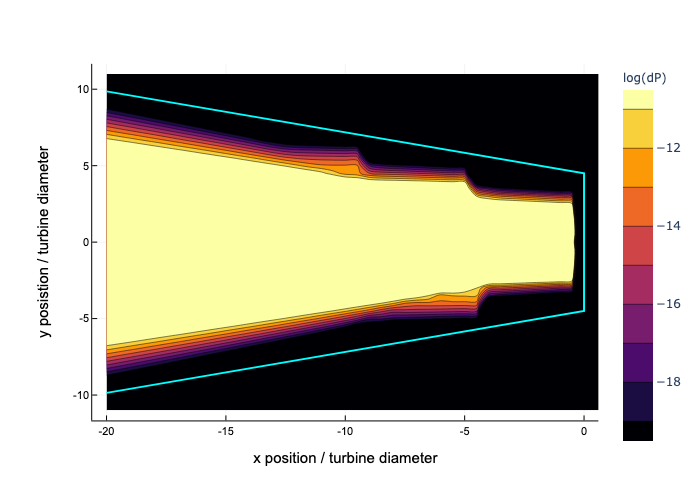

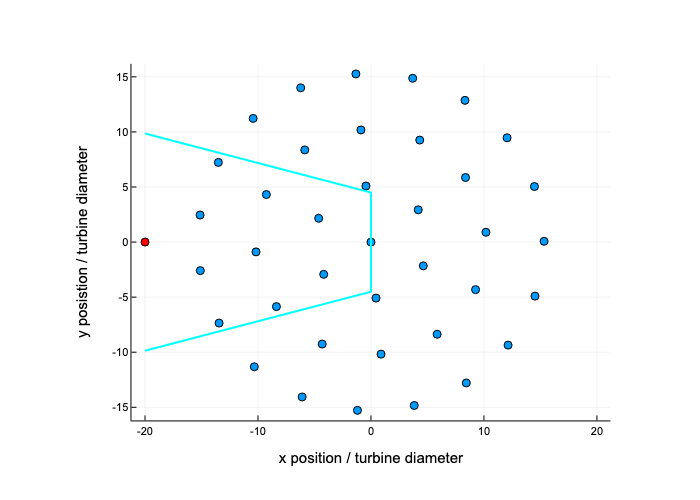

In [8]:
x_turbine,y_turbine = loadAllParam(0,39,95)
x_turbines = [x_turbine;-15*80] ./80
y_turbines = [y_turbine;0] ./80

global s = [copy(x_turbines);copy(y_turbines)]

plotlyjs()
xpos = collect(-20:.5:1)
ypos = collect(-11:.5:11)

function contourJac(x,y)
    s[39] = x
    s[end] = y
    temp = ForwardDiff.jacobian(p_wrapper_single,s.*80)
    temp = log10(hypot(temp[1,39],temp[1,78])+1E-50)
end
function contourJacx(x,y)
    s[39] = x
    s[end] = y
    temp = ForwardDiff.jacobian(p_wrapper_single,s.*80)
    temp = log10(abs(temp[1,39])+1E-50)
end
function contourJacy(x,y)
    s[39] = x
    s[end] = y
    temp = ForwardDiff.jacobian(p_wrapper_single,s.*80)
    temp = log10(abs(temp[1,78])+1E-50)
end

lim = (-20,-10)

h = 4.5
d = 0 #3.6
theta = 15
delta_x = xpos[1]
delta_y = ypos[1]
left = h + abs(delta_x)*tand(theta)
p1 = contour(xpos,ypos,contourJac,
    fill=true,
    # title="38 Turbine",
    xlabel="x position / turbine diameter",
    colorbar_title="log(dP)",
    ylabel="y posistion / turbine diameter",
    clims = lim,
    transparent=true)
    
p1 = plot(p1,transpose([delta_x -d 0 0 -d delta_x]),transpose([-left -h -h h h left]),
    color=:cyan,
    legend=false,
    xlim=[delta_x,0],
    ylim=[delta_y,-delta_y],
    linewidth = 2)
display(p1)

p4 = scatter(x_turbine[1:end]./80,y_turbine[1:end]./80,
    xlabel="x position / turbine diameter",
    ylabel="y posistion / turbine diameter",
    legend=false,
    aspect_ratio=1)

p4 = plot(p4,transpose([delta_x -d 0 0 -d delta_x]),transpose([-left -h -h h h left]),
    color=:cyan,
    legend=false,
    linewidth = 2,
    xlim = [-20,20])

p4 = scatter(p4,[-20],[0],color=:red)
    
display(p4)